In [1]:
!pip install -q kaggle


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lokmanmihoubi","key":"fd8f5a1d7ad8f48d5e9c5b71638a8032"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

 99% 1.75G/1.76G [00:11<00:00, 172MB/s]
100% 1.76G/1.76G [00:11<00:00, 158MB/s]


In [7]:
!unzip -q /content/lung-and-colon-cancer-histopathological-images.zip

In [8]:
import pandas as pd
import numpy as np
from os import listdir
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, model_from_json
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
import itertools
import time
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,make_scorer

In [9]:
DIR = '/content/lung_colon_image_set/lung_image_sets'


data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 128

X = Y = 224

train_ds = data.flow_from_directory(DIR,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

Found 12000 images belonging to 3 classes.


In [10]:
validation = data.flow_from_directory(DIR,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 3000 images belonging to 3 classes.


In [11]:

folders = glob('/content/lung_colon_image_set/lung_image_sets' + '/*')

In [12]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [13]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

In [14]:

pretrained_model_1 = VGG16(include_top=False, input_shape=(X, Y, 3))
base_model = pretrained_model_1 # Topless
num_classes = 3
optimizer1 = Adam()
# Add top layer
x = base_model.output
x = Conv2D(80, kernel_size = (3,3), padding = 'valid')(x)
x = Flatten()(x)
x = Dropout(0.75)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# Train top layer
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer1, 
                  metrics=['accuracy'])
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

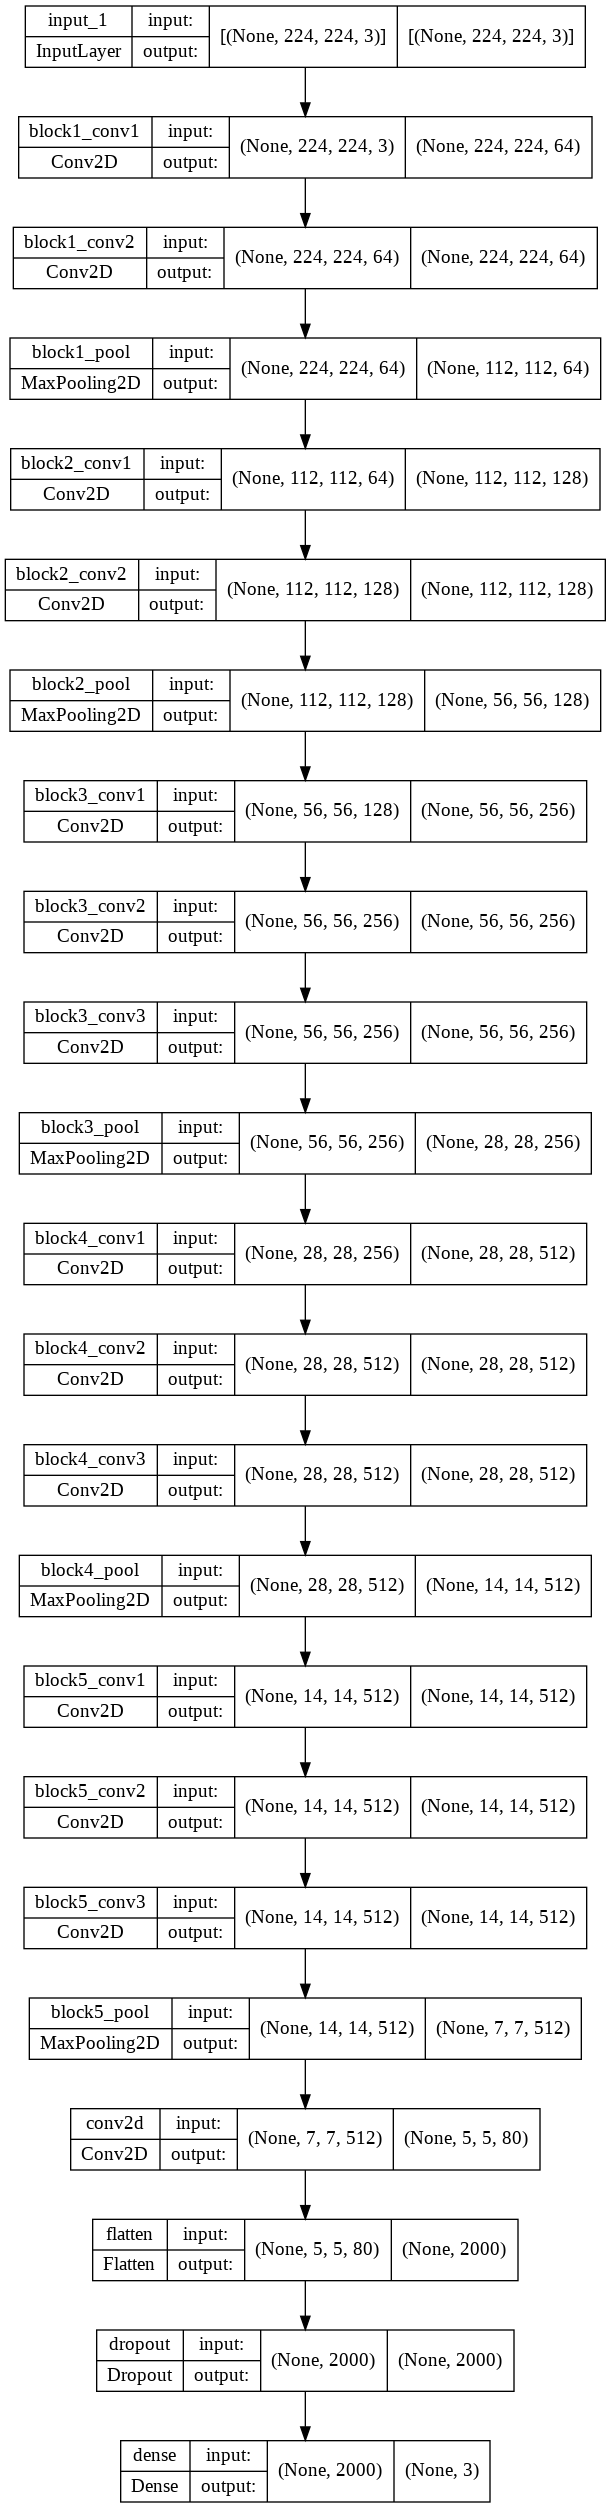

In [15]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='NN-mnist.png', show_shapes=True)

In [17]:
def create_model_check_point_callback(checkpoint_path,monitor='val_loss'):
    """
    Takes the path where to save the best model weights obtained during training.
    """
    model_checkpoint_cb=tf.keras.callbacks.ModelCheckpoint(
        
        monitor=monitor,
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    return model_checkpoint_cb
ModelCheckPoint_model_cb=create_model_check_point_callback('ModelCheckPoints/model.ckpt')    

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(
    train_ds,
    validation_data=validation,
    epochs=30,
    callbacks=[ ModelCheckPoint_model_cb,early_stopping])

Epoch 1/30
94/94 [==============================] - ETA: 0s - loss: 11.3283 - accuracy: 0.7746
Epoch 1: val_loss improved from inf to 0.88419, saving model to ModelCheckPoints/model.ckpt
94/94 [==============================] - 150s 2s/step - loss: 11.3283 - accuracy: 0.7746 - val_loss: 0.8842 - val_accuracy: 0.9580
Epoch 2/30
94/94 [==============================] - ETA: 0s - loss: 1.8962 - accuracy: 0.9271
Epoch 2: val_loss improved from 0.88419 to 0.78028, saving model to ModelCheckPoints/model.ckpt
94/94 [==============================] - 141s 2s/step - loss: 1.8962 - accuracy: 0.9271 - val_loss: 0.7803 - val_accuracy: 0.9530
Epoch 3/30
94/94 [==============================] - ETA: 0s - loss: 1.0456 - accuracy: 0.9535
Epoch 3: val_loss improved from 0.78028 to 0.60609, saving model to ModelCheckPoints/model.ckpt
94/94 [==============================] - 140s 1s/step - loss: 1.0456 - accuracy: 0.9535 - val_loss: 0.6061 - val_accuracy: 0.9643
Epoch 4/30
94/94 [========================

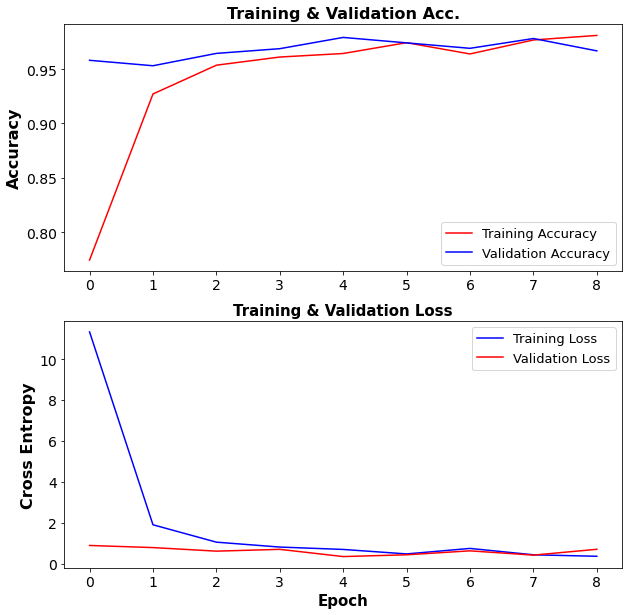

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='red')
plt.plot(val_acc, label='Validation Accuracy', color='blue')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

In [22]:
from sklearn.metrics import classification_report

Y_pred = model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.99      0.95      1000
           1       1.00      1.00      1.00      1000
           2       0.99      0.91      0.95      1000

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

Normalized confusion matrix


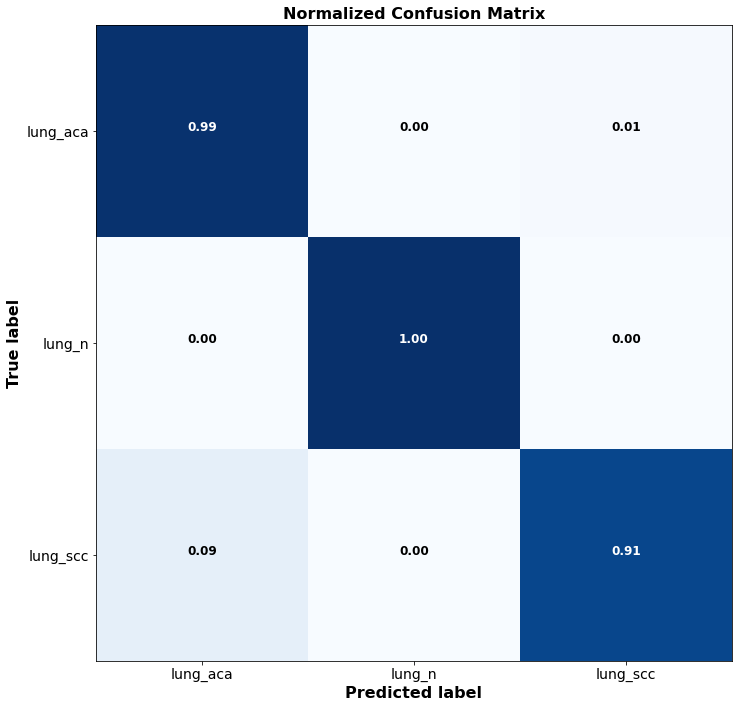

In [26]:
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()

In [27]:
model.save("model_lung.h5")
from keras.models import load_model
model=load_model('model_lung.h5')

In [28]:
from keras.preprocessing import image

In [30]:
imagePath=('/content/lungn100.jpeg')
test_image = image.load_img(imagePath, target_size = (224, 224)) 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
